In [1]:
import time
import casadi
import example_robot_data as robex
import numpy as np
from utils.Lagrange import *
from utils.LGL_collocation import LGL_collocation
from utils.LocalChart import *
import pinocchio as pin
from pinocchio import casadi as cpin
import matplotlib.pyplot as plt

In [2]:
robot = robex.load("ur10")
model = robot.model
data = robot.data

cmodel = cpin.Model(model)
cdata = cmodel.createData()
nq = model.nq   # Number of joints
nv = model.nv   # Number of DOF
nx = nq + nv    # Number of states
cx = casadi.SX.sym("x", nx, 1)
ctau = casadi.SX.sym("tau", nv, 1)
cacc = cpin.aba(cmodel, cdata, cx[:nq], cx[nq:], ctau) # Forward dynamics

# Joint limits
lowerVelocityLimit = np.pi/2 * np.array([-1, -1, -1, -1, -1, -1])  # rad/s
upperVelocityLimit = np.pi/2 * np.array([1, 1, 1, 1, 1, 1])
lowerTorqueLimit = 100 * np.array([-1, -1, -1, -1, -1, -1]) 
upperTorqueLimit = 100 * np.array([1, 1, 1, 1, 1, 1])
print(model.upperPositionLimit)
print(model.lowerPositionLimit)

waypoints = np.array([[0, np.pi/4, 0, 0, 0, 0], 
                      [-np.pi/4, np.pi/4, np.pi/3, 0, -np.pi/6, 0]])
q0 = waypoints[0]
robot.q0 = q0
qT = waypoints[-1]
tau0 = pin.rnea(model, data, q0, np.zeros(nv), np.zeros(nv))
tauT = pin.rnea(model, data, qT, np.zeros(nv), np.zeros(nv))
print(tau0)
print(tauT)
print(pin.computeGeneralizedGravity(model, data, qT))

[6.28318531 6.28318531 3.14159265 6.28318531 6.28318531 6.28318531]
[-6.28318531 -6.28318531 -3.14159265 -6.28318531 -6.28318531 -6.28318531]
[-8.88178420e-16 -8.52573478e+01 -2.38834632e+01  1.62120800e-01
  0.00000000e+00  0.00000000e+00]
[ 3.55271368e-15 -5.23511289e+01  9.02275572e+00  2.21461131e-01
  0.00000000e+00  0.00000000e+00]
[ 3.55271368e-15 -5.23511289e+01  9.02275572e+00  2.21461131e-01
  0.00000000e+00  0.00000000e+00]


In [3]:
Ntp = 9    # Number of collocation points / basis (degree: Ntp-1)
Np = 1       # Number of phase (dersired waypoints: N+1)
T = Np*Ntp   # Number of total collocation points / optimization variables

LGL_Pts, LGL_Wts = Normalize_LGL_Pts_Wts(Ntp)
DL,_ = differentiation_matrix(Ntp, LGL_Pts)
LGL = LGL_collocation(Ntp, nq, nv)
StatesDiff, StateDiff, LocalsDiff, LocalDiff= LGL.getDiffFuncs()

Feq = casadi.Function(
    "Dyn",
    [cx, ctau],
    [casadi.vertcat(cx[nq:], cacc)],
)

'''CasADi.Function only accepts [SX], [MX] as variables'''
LGL_Pts, LGL_Wts = Normalize_LGL_Pts_Wts(Ntp) # LGL points
DL, _ = differentiation_matrix(Ntp, LGL_Pts)  # Differentiation matrices
#print(DL)

In [4]:
opti = casadi.Opti()
# Optimization variables
var_xs = [opti.variable(nx) for _ in range(T)]
var_us = [opti.variable(nv) for _ in range(T)]
var_deltaT = [opti.variable(1) for _ in range(Np)]

# Constraints
for i in range(Np):
    opti.subject_to(var_deltaT[i] > 0.0)

    for tp in range(Ntp):
        t = i*Ntp + tp
        # dynamics
        opti.subject_to(StateDiff(casadi.vertcat(*var_xs[i*Ntp: (i+1)*Ntp]), var_deltaT[i], DL[tp,:]) 
                        == Feq(var_xs[t], var_us[t]))
        
        # joint constraints
        opti.subject_to(var_xs[t][:nq] <= model.upperPositionLimit)
        opti.subject_to(var_xs[t][:nq] >= model.lowerPositionLimit)
        # joint velocity constraints
        opti.subject_to(var_xs[t][nq:] <= upperVelocityLimit)
        opti.subject_to(var_xs[t][nq:] >= lowerVelocityLimit)
        # torque constraints
        opti.subject_to(var_us[t] <= upperTorqueLimit)
        opti.subject_to(var_us[t] >= lowerTorqueLimit)


# boundary conditions
opti.subject_to(var_xs[0][:nq] == q0)
opti.subject_to(var_xs[-1][:nq] == qT)
opti.subject_to(var_xs[0][nq:] == 0)
opti.subject_to(var_xs[-1][nq:] == 0)
#opti.subject_to(var_us[0] == tau0)
opti.subject_to(var_us[-1] == tauT)


# Objective
totalcost = 0

R = np.eye(nv)
for i in range(Np):
    for tp in range(Ntp):
        var_xs_Phase = var_xs[i*Ntp: (i+1)*Ntp]
        dq = [dq_Phase[nq:] for dq_Phase in var_xs_Phase]
        ddq = StateDiff(casadi.vertcat(*dq), var_deltaT[i], DL[tp,:])
        totalcost += var_deltaT[i]/2 * LGL_Wts[tp] * casadi.mtimes([ddq.T, R, ddq])
        
    totalcost += var_deltaT[i]

opti.minimize(totalcost)
opti.solver("ipopt") 

for x in var_xs:
    opti.set_initial(x, np.concatenate([robot.q0, np.zeros(nv)]))
for u in var_us:
    opti.set_initial(u, tau0)
for t in var_deltaT:
    opti.set_initial(t, 0.5)

In [5]:
try:
    sol = opti.solve_limited()
    sol_xs = [opti.value(var_x) for var_x in var_xs]
    sol_us = [opti.value(var_u) for var_u in var_us]
    sol_T = [opti.value(var_t) for var_t in var_deltaT]
except:
    print("ERROR in convergence, plotting debug info.")
    sol_xs = [opti.debug.value(var_x) for var_x in var_xs]
    sol_us = [opti.debug.value(var_u) for var_u in var_us]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.2.

Number of nonzeros in equality constraint Jacobian...:     2082
Number of nonzeros in inequality constraint Jacobian.:      325
Number of nonzeros in Lagrangian Hessian.............:     2431

Total number of variables............................:      163
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      138
Total number of inequality c

### Dynamics Simulations

In [6]:
print(sol_T)
print(LGL_Pts)
collo_pts = sol_T[0]/2 * (LGL_Pts+1)
print(collo_pts)

t = casadi.SX.sym("t")
inter_xs = casadi.Function(
    "xt", 
    [t], [LagrangeInterpolation(t, collo_pts, sol_xs)]
)
inter_us = casadi.Function(
    "ut", 
    [t], [LagrangeInterpolation(t, collo_pts, sol_us)]
)
inter_dxs = casadi.Function(
    "dxt", 
    [t], [DiffLangrangeInterpolation(t, collo_pts, sol_xs)]
)



[2.95574265504345]
[-1.00000000e+00 -8.99757995e-01 -6.77186280e-01 -3.63117464e-01
  8.53457639e-17  3.63117464e-01  6.77186280e-01  8.99757995e-01
  1.00000000e+00]
[0.         0.14814478 0.47707714 0.94123044 1.47787133 2.01451222
 2.47866551 2.80759787 2.95574266]


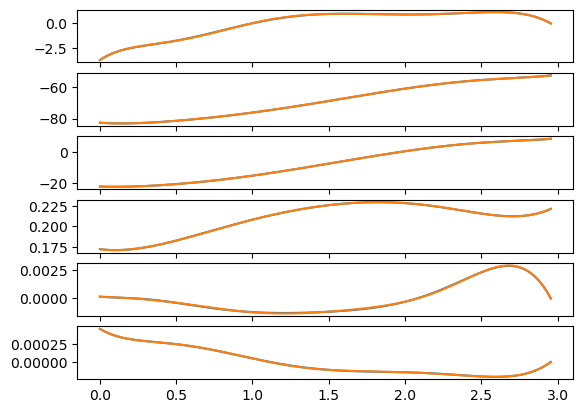

In [7]:
# Inverse dynamics
sample_t = np.linspace(0, sol_T, 200)
sample_q = np.array([inter_xs(t)[:nq] for t in sample_t])
sample_dq = np.array([inter_xs(t)[nq:] for t in sample_t])
sample_ddq = np.array([inter_dxs(t)[nv:] for t in sample_t])
# from interpolation
sample_u = np.array([inter_us(t) for t in sample_t])
# from dynamics equations
tau_id = np.array([pin.rnea(model, data, q, dq, ddq) for q, dq, ddq in zip(sample_q, sample_dq, sample_ddq)])

# plot sample_u and tau
fig, axs = plt.subplots(nv,1)
for i in range(nv): 
    axs[i].plot(sample_t, sample_u[:,i], label=f'u{i}')
    axs[i].plot(sample_t, tau_id[:,i], label=f'tau{i}')
plt.show()

In [11]:
# Forward dynamics
def ForwardDynamics(x, t):
    q = x[:nq]
    dq = x[nq:]
    u = inter_us(t)
    ddq = cpin.aba(cmodel, cdata, q, dq, u)
    return casadi.vertcat(dq, ddq)


#print(inter_us(0))

<function ForwardDynamics at 0x000001AAA417FDC0>


In [12]:
# Define the ODE function
x = casadi.SX.sym("x", nx, 1)
t = casadi.SX.sym('t')
print(ForwardDynamics(x,t))
#FD = casadi.Function('ForwardDynamics', [x, t], [ForwardDynamics(x, t)])
#print(FD(np.concatenate([robot.q0, np.zeros(nv)]), 0))

ode = {'x': x, 't': t, 'ode': ForwardDynamics(x,t)}
time_steps = np.linspace(0, sol_T[0], 51)
opts = {
    't0':0.0,
    'tf': sol_T[0],                  # Final time
    'abstol': 1e-8,             # Absolute tolerance
    'reltol': 1e-8,             # Relative tolerance
    'max_num_steps': 10000,     # Maximum number of steps
    'output_t0': True,          # Include the initial condition in the output
    'record_time': True,        # Record the time steps
    'grid': time_steps # Specify the grid for output steps
}
integrator = casadi.integrator('integrator', 'cvodes', ode, opts)
print(ode)


# ODE solver
x0 = np.concatenate([robot.q0, np.zeros(nv)])
result = integrator(x0=x0)
states = result['xf']

# Print the intermediate steps
for i, time in enumerate(time_steps):
    print(f"Time: {time}, State: {states[:, i]}")

@1=0.148145, @2=0.477077, @3=0.94123, @4=1.47787, @5=-1.47787, @6=2.01451, @7=2.47867, @8=2.8076, @9=-2.8076, @10=2.95574, @11=(((((((((t-@1)/-0.148145)*((t-@2)/-0.477077))*((t-@3)/-0.94123))*((t-@4)/@5))*((t-@6)/-2.01451))*((t-@7)/-2.47867))*((t-@8)/@9))*((t-@10)/-2.95574)), @12=((((((((t/@1)*((t-@2)/-0.328932))*((t-@3)/-0.793086))*((t-@4)/-1.32973))*((t-@6)/-1.86637))*((t-@7)/-2.33052))*((t-@8)/-2.65945))*((t-@10)/@9)), @13=((((((((t/@2)*((t-@1)/0.328932))*((t-@3)/-0.464153))*((t-@4)/-1.00079))*((t-@6)/-1.53744))*((t-@7)/-2.00159))*((t-@8)/-2.33052))*((t-@10)/-2.47867)), @14=((((((((t/@3)*((t-@1)/0.793086))*((t-@2)/0.464153))*((t-@4)/-0.536641))*((t-@6)/-1.07328))*((t-@7)/-1.53744))*((t-@8)/-1.86637))*((t-@10)/-2.01451)), @15=((((((((t/@4)*((t-@1)/1.32973))*((t-@2)/1.00079))*((t-@3)/0.536641))*((t-@6)/-0.536641))*((t-@7)/-1.00079))*((t-@8)/-1.32973))*((t-@10)/@5)), @16=((((((((t/@6)*((t-@1)/1.86637))*((t-@2)/1.53744))*((t-@3)/1.07328))*((t-@4)/0.536641))*((t-@7)/-0.464153))*((t-@8)/-

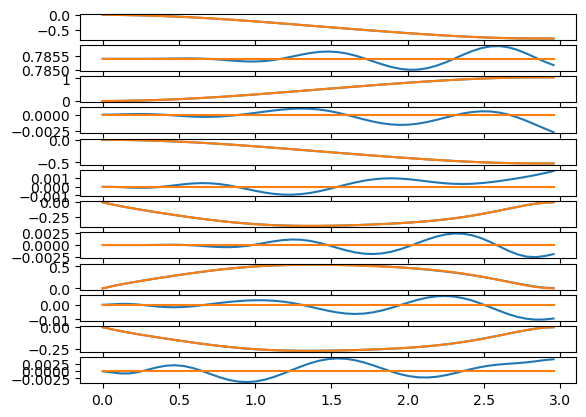

In [10]:
nominal_q = np.array([inter_xs(t)[:nq] for t in time_steps])
nominal_dq = np.array([inter_xs(t)[nq:] for t in time_steps])

fig, axs = plt.subplots(nq+nv, 1)
for i in range(nq):
    axs[i].plot(time_steps, states[i, :].reshape((len(time_steps),1)))
    axs[i].plot(time_steps, nominal_q[:,i])
    #axs[i].set_ylim(-0.5, 0.5)
for i in range(nq, nq+nv):
    axs[i].plot(time_steps, states[i, :].reshape((len(time_steps),1)))
    axs[i].plot(time_steps, nominal_dq[:,i-nq])
    #axs[i].set_ylim(-0.5, 0.5)
plt.show()